<a href="https://colab.research.google.com/github/temesgenm/Calculate-Precipitation-based-Agricultural-Drought-Indices-with-Python/blob/master/Tutorial_Python_Geospatial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

By: Ali Ahmadalipour ([LinkedIn](https://www.linkedin.com/in/ahmadalipour/), [Twitter](https://twitter.com/hydroclimali))

April 2022

Link to a LinkedIn article I wrote explaining the details: https://www.linkedin.com/pulse/python-climate-data-analysis-tutorial-code-ali-ahmadalipour/

***Basic info for running the code in a notebook environment:***
+ To run a cell, press Shift + Enter
+ To restart the analysis (i.e. clean the variables and RAM, but keep the downloaded data), restart the runtime from the top menu
+ To completely start over (i.e. clean RAM and temporary storage that may contain downloaded data or any saved figure), go to Runtime>Manage sessions->TERMINATE.


***Basic info about Google Colab Notebooks:***
* If the page stays idle for several minutes, the runtime may be terminated, and you'll need to connect again.
* Google provides you about 70GB free temporary disk space. Any data you download or any model output is by default saved temporarily in this terminal. Therefore, if the runtime is terminated, you'll lose that data. If you would like to keep the data or the outputs, you can connect to your Google drive and choose any specific directory there. Here's how to connect to your google drive:
```
# from google.colab import drive
# drive.mount('/content/drive')
```

------------
------------


# 1. Basic (download, extract & save data, concat, groupby, select):

In this section, we will download and analyze gridded precipitation data (from CPC). The goal is to extract daily data, find monthly totals, find spatial average of precipitation in a given domain, plot the results, and save the outputs as netcdf files.
We will work with some of the commonly used functionalities of [xarray](https://docs.xarray.dev/en/stable/) (a powerful python library for analyzing geospatial data) such as:
- open_mfdataset (in xarray, which opens multiple files at the same time)
- concatenate datasets
- groupby
- slicing and selecting data
- save as netcdf


In [3]:
# Later in the advanced section of this tutorial (section 3.2), we will be analyzing
# zarr data format, and the pre-installed xarray on google colab is not able to
# do so. Thus, we need to intall the complete version of xarray to be able to do it.
!pip install xarray[complete] # this may take a few seconds

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.5/47.5 kB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of dask-expr to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 81.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 50.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.0/70.0 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 73.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.2/49.2 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 237.3/237.3 kB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.7/210.7 kB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 58.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 86.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━

In [4]:
# Update to code (Oct 16, 2022): It seems that the updated xarray library runs
# into an error when trying to open a netcdf dataset. I searched for the issue,
# and it seems we need to downgrade the importlib-metadata library to make the
# libraries compatible.
!pip install importlib-metadata==4.13.0

  Attempting uninstall: importlib-metadata
    Found existing installation: importlib_metadata 8.5.0
    Uninstalling importlib_metadata-8.5.0:
      Successfully uninstalled importlib_metadata-8.5.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opentelemetry-api 1.28.2 requires importlib-metadata<=8.5.0,>=6.0, but you have importlib-metadata 4.13.0 which is incompatible.


In [5]:
import glob
import matplotlib.pyplot as plt
import urllib.request
import xarray as xr

In [6]:
for yr in range(2011,2015): # note that in python, the end range is not inclusive. So, in this case data for 2015 is not downloaded.
    url = f'https://downloads.psl.noaa.gov/Datasets/cpc_us_precip/RT/precip.V1.0.{yr}.nc'
    savename = url.split('/')[-1]
    urllib.request.urlretrieve(url,savename)

Let's start simple: open data for two years and concatenate them to one file:

In [7]:
ds2011 = xr.open_dataset('precip.V1.0.2011.nc')
ds2012 = xr.open_dataset('precip.V1.0.2012.nc')

In [8]:
ds2011

<xarray.Dataset> Size: 53MB
Dimensions:  (lat: 120, lon: 300, time: 365)
Coordinates:
  * lat      (lat) float32 480B 20.12 20.38 20.62 20.88 ... 49.38 49.62 49.88
  * lon      (lon) float32 1kB 230.1 230.4 230.6 230.9 ... 304.4 304.6 304.9
  * time     (time) datetime64[ns] 3kB 2011-01-01 2011-01-02 ... 2011-12-31
Data variables:
    precip   (time, lat, lon) float32 53MB ...
Attributes:
    title:          CPC Unified Gauge-Based Analysis of Daily Precipitation o...
    Conventions:    COARDS
    description:    Gridded daily Precipitation
    platform:       Observations
    Comments:       Preciptation is accumulated from 12z of previous day to 1...
    history:        originally created RT starting 04/2010 by CAS from data o...
    dataset_title:  CPC Unified Gauge-Based Analysis of Daily Precipitation o...
    References:     http://www.psl.noaa.gov/data/gridded/data.unified.daily.c...

In [9]:
ds2012

<xarray.Dataset> Size: 53MB
Dimensions:  (lat: 120, lon: 300, time: 366)
Coordinates:
  * lat      (lat) float32 480B 20.12 20.38 20.62 20.88 ... 49.38 49.62 49.88
  * lon      (lon) float32 1kB 230.1 230.4 230.6 230.9 ... 304.4 304.6 304.9
  * time     (time) datetime64[ns] 3kB 2012-01-01 2012-01-02 ... 2012-12-31
Data variables:
    precip   (time, lat, lon) float32 53MB ...
Attributes:
    title:          CPC Unified Gauge-Based Analysis of Daily Precipitation o...
    Conventions:    COARDS
    description:    Gridded daily Precipitation
    platform:       Observations
    Comments:       Preciptation is accumulated from 12z of previous day to 1...
    history:        originally created RT starting 04/2010 by CAS from data o...
    dataset_title:  CPC Unified Gauge-Based Analysis of Daily Precipitation o...
    References:     http://www.psl.noaa.gov/data/gridded/data.unified.daily.c...

In [10]:
ds2011_2012 = xr.concat([ds2011,ds2012], dim='time')

In [11]:
ds2011_2012

<xarray.Dataset> Size: 105MB
Dimensions:  (time: 731, lat: 120, lon: 300)
Coordinates:
  * lat      (lat) float32 480B 20.12 20.38 20.62 20.88 ... 49.38 49.62 49.88
  * lon      (lon) float32 1kB 230.1 230.4 230.6 230.9 ... 304.4 304.6 304.9
  * time     (time) datetime64[ns] 6kB 2011-01-01 2011-01-02 ... 2012-12-31
Data variables:
    precip   (time, lat, lon) float32 105MB nan nan nan nan ... nan nan nan nan
Attributes:
    title:          CPC Unified Gauge-Based Analysis of Daily Precipitation o...
    Conventions:    COARDS
    description:    Gridded daily Precipitation
    platform:       Observations
    Comments:       Preciptation is accumulated from 12z of previous day to 1...
    history:        originally created RT starting 04/2010 by CAS from data o...
    dataset_title:  CPC Unified Gauge-Based Analysis of Daily Precipitation o...
    References:     http://www.psl.noaa.gov/data/gridded/data.unified.daily.c...

Now, let's try something similar, but through a more efficient way (especially if the number of files are more than two):

In [12]:
ds2011_2014 = xr.open_mfdataset('precip.V1.0.*.nc', concat_dim='time', combine='nested')
# Or, you can use the following command to do the same thing:
# ds2011_2014 = xr.open_mfdataset('precip*.nc', combine='by_coords')

In [13]:
ds2011_2014

<xarray.Dataset> Size: 210MB
Dimensions:  (time: 1461, lat: 120, lon: 300)
Coordinates:
  * lat      (lat) float32 480B 20.12 20.38 20.62 20.88 ... 49.38 49.62 49.88
  * lon      (lon) float32 1kB 230.1 230.4 230.6 230.9 ... 304.4 304.6 304.9
  * time     (time) datetime64[ns] 12kB 2011-01-01 2011-01-02 ... 2014-12-31
Data variables:
    precip   (time, lat, lon) float32 210MB dask.array<chunksize=(1, 120, 300), meta=np.ndarray>
Attributes:
    title:          CPC Unified Gauge-Based Analysis of Daily Precipitation o...
    Conventions:    COARDS
    description:    Gridded daily Precipitation
    platform:       Observations
    Comments:       Preciptation is accumulated from 12z of previous day to 1...
    history:        originally created RT starting 04/2010 by CAS from data o...
    dataset_title:  CPC Unified Gauge-Based Analysis of Daily Precipitation o...
    References:     http://www.psl.noaa.gov/data/gridded/data.unified.daily.c...

Now let's focus on 2012 and extract the monthly precipitation sum and make a simple plot of one of the months:

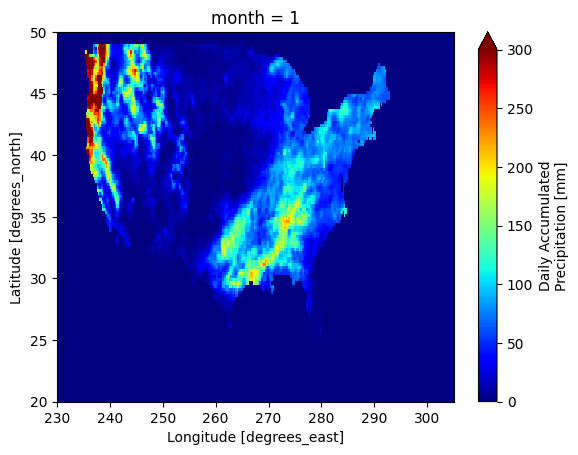

In [14]:
# The great thing about groupby is that you do not need to worry about the leap years or
# number of days in each month.
# In addition, xarray is label-aware and when you pass the plot function, it understands that you want to
# make a spatial plot and finds the lat and lon values and the appropriate title and labels.
ds2012_mon = ds2012.groupby('time.month').sum()
ds2012_mon.precip[0,:,:].plot(cmap='jet', vmax=300)

The above plot is quite simple and not high quality (e.g. the areas outside the US boundary had no data and are all shown in dark blue, both x & y axis limits are a bit large and can be narrowed down, the title is not exactly what we may like, etc.). We will now develop a more personalized plot for all the 12 months as follows:

In [15]:
import calendar # We'll use this library to easily add month name to subplot titles.

In [16]:
# First, We will develop a land mask data array that we can use to mask out the nan values:
landmask = ds2012.precip.sum(dim='time')>0

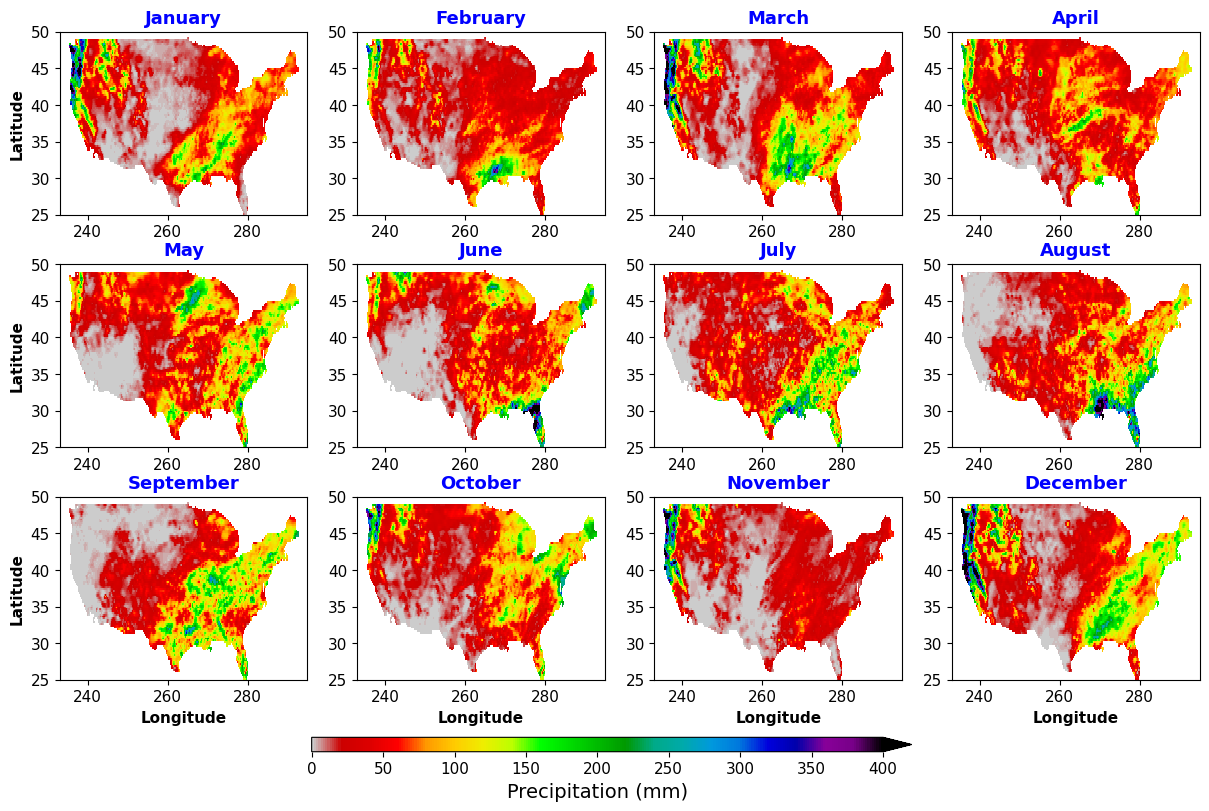

In [17]:
fig = plt.figure(figsize=[12,8], facecolor='w')
plt.subplots_adjust(bottom=0.15, top=0.96, left=0.04, right=0.99,
                    wspace=0.2, hspace=0.27) # wspace and hspace adjust the horizontal and vertical spaces, respectively.
nrows = 3
ncols = 4
for i in range(1, 13):
    plt.subplot(nrows, ncols, i)
    dataplot = ds2012_mon.precip[i-1, :, :].where(landmask) # Remember that in Python, the data index starts at 0, but the subplot index start at 1.
    p = plt.pcolormesh(ds2012_mon.lon, ds2012_mon.lat, dataplot,
                   vmax = 400, vmin = 0, cmap = 'nipy_spectral_r',
                   )
    plt.xlim([233,295])
    plt.ylim([25,50])
    plt.title(calendar.month_name[dataplot.month.values], fontsize = 13,
              fontweight = 'bold', color = 'b')
    plt.xticks(fontsize = 11)
    plt.yticks(fontsize = 11)
    if i % ncols == 1: # Add ylabel for the very left subplots
        plt.ylabel('Latitude', fontsize = 11, fontweight = 'bold')
    if i > ncols*(nrows-1): # Add xlabel for the bottom row subplots
        plt.xlabel('Longitude', fontsize = 11, fontweight = 'bold')

# Add a colorbar at the bottom:
cax = fig.add_axes([0.25, 0.06, 0.5, 0.018])
cb = plt.colorbar(cax=cax, orientation='horizontal', extend = 'max',)
cb.ax.tick_params(labelsize=11)
cb.set_label(label='Precipitation (mm)', color = 'k', size=14)

# Now we can save a high resolution (300dpi) version of the figure:
plt.savefig('Fig_prec_cpc_mon_2012.png', format = 'png', dpi = 300)

Now let's say we want to extract data for a specific boundary and look at the average condition within that area of interest. For simplicity, we can think of a rectangular box (but you can easily develop any landmask as above and use it to focus on only your domain of interest). For this case, let's look at a rectangular box almost similar to the state of Kansas.

In [18]:
top = 40
bottom = 37
left = 258
right = 265.4

In [19]:
ds_sel = ds2011_2014.sel(lon=slice(left,right), lat=slice(bottom, top))
ds_sel_avg = ds_sel.mean(dim=['lat','lon'])

Now let's plot the cumulative daily precipitation of the selected area for each year. To make things easier, let's drop Feb 29th from any leap years in the record. Here we go:

In [20]:
ds_sel_avg_noleap = ds_sel_avg.sel(
    time=~((ds_sel_avg.time.dt.month == 2) & (ds_sel_avg.time.dt.day == 29)))

In [21]:
# Here's how the result will look like:
ds_sel_avg_noleap

<xarray.Dataset> Size: 18kB
Dimensions:  (time: 1460)
Coordinates:
  * time     (time) datetime64[ns] 12kB 2011-01-01 2011-01-02 ... 2014-12-31
Data variables:
    precip   (time) float32 6kB dask.array<chunksize=(1,), meta=np.ndarray>

In [22]:
# Now we can easily save that output as a netcdf file using xarray:
ds_sel_avg_noleap.to_netcdf('ds_prec_Kansas_noleap_2011_2014.nc')

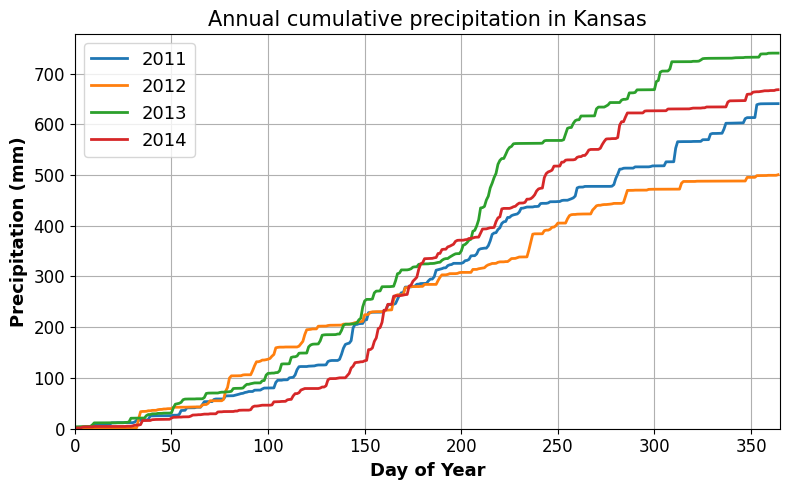

In [23]:
fig = plt.figure(figsize=[8,5], facecolor='w')
for yr in range(2011,2015):
    da_yr = ds_sel_avg_noleap.sel(time = str(yr)).precip
    dataplot = da_yr.cumsum()
    plt.plot(dataplot, linewidth=2, label = yr)
plt.legend(fontsize=13)
plt.grid()
plt.xticks(fontsize=12) # we can also change the ticks to be on Jan-1, Feb-1, etc. but I'll skip it for here.
plt.yticks(fontsize=12)
plt.ylabel('Precipitation (mm)', fontsize = 13, fontweight = 'bold')
plt.xlabel('Day of Year', fontsize = 13, fontweight = 'bold')
plt.xlim([0,365])
plt.ylim(bottom=0)
plt.title('Annual cumulative precipitation in Kansas', fontsize=15)
plt.tight_layout()
plt.savefig('Fig_cumsum_prec_Kansas.png', format = 'png', dpi = 300)

We could also do a little more modification to revise the xticklabels and show the exact month and day values (instead of julian day number). See if you can figure it out yourself.

-------------------------------------------------------------
-------------------------------------------------------------


# 2. Intermediate (interpolate, revise coordinates, rolling average):

For this section, we will dive deeper. We will be using two different datasets with different resolutions and we will work with interpolation. The two datasets that I have considered are CPC-Globe and gridMet minimum air temperature data. CPC-Globe has a 0.5 degree (~ 50km) spatial resolution, whereas the same for gridMET is 1/24 degree (~ 4km).
Here's a summary of the main functionalities that we will be practicing in this section:
+ Interpolation
+ Converting 0:360 longitude axis to -180:180
+ Scaling a dataset (e.g. convert degrees Kelvin to degrees Celcius)
+ Rolling average (with any time window)

In [24]:
# I import the libraries again, to keep the examples separate from each other (in case someone wants to start from here).
import urllib.request
import xarray as xr
import matplotlib.pyplot as plt
import datetime
import pandas as pd

Let's download the two datasets for 2021:


In [25]:
# Downloading GridMet tmin (1/24 deg, ~4km):
url = 'https://www.northwestknowledge.net/metdata/data/tmmn_2021.nc'
savename = 'tmin_gridmet_2021.nc'
urllib.request.urlretrieve(url, savename)

# Downloading CPC-Globe tmin (0.5 deg, ~50km):
url = 'https://downloads.psl.noaa.gov/Datasets/cpc_global_temp/tmin.2021.nc'
savename = 'tmin_CPC_2021.nc'
urllib.request.urlretrieve(url, savename)

('tmin_CPC_2021.nc', <http.client.HTTPMessage at 0x7cf999d80310>)

In [26]:
# Now lets open the two datasets and explore them:
ds_gridmet = xr.open_dataset('tmin_gridmet_2021.nc')
ds_CPC = xr.open_dataset('tmin_CPC_2021.nc')

In [27]:
ds_gridmet

<xarray.Dataset> Size: 2GB
Dimensions:          (lon: 1386, lat: 585, day: 365, crs: 1)
Coordinates:
  * lon              (lon) float64 11kB -124.8 -124.7 -124.7 ... -67.1 -67.06
  * lat              (lat) float64 5kB 49.4 49.36 49.32 ... 25.15 25.11 25.07
  * day              (day) datetime64[ns] 3kB 2021-01-01 ... 2021-12-31
  * crs              (crs) uint16 2B 3
Data variables:
    air_temperature  (day, lat, lon) float64 2GB ...
Attributes: (12/19)
    geospatial_bounds_crs:      EPSG:4326
    Conventions:                CF-1.6
    geospatial_bounds:          POLYGON((-124.7666666333333 49.40000000000000...
    geospatial_lat_min:         25.066666666666666
    geospatial_lat_max:         49.40000000000000
    geospatial_lon_min:         -124.7666666333333
    ...                         ...
    date:                       30 March 2023
    note1:                      The projection information for this file is: ...
    note2:                      Citation: Abatzoglou, J.T., 2013, Development...
    note3:                      Data in slices after last_permanent_slice (1-...
    note4:                      Data in slices after last_provisional_slice (...
    note5:                      Days correspond approximately to calendar day...

In [ ]:
ds_CPC

<xarray.Dataset> Size: 378MB
Dimensions:  (lat: 360, lon: 720, time: 365)
Coordinates:
  * lat      (lat) float32 1kB 89.75 89.25 88.75 88.25 ... -88.75 -89.25 -89.75
  * lon      (lon) float32 3kB 0.25 0.75 1.25 1.75 ... 358.2 358.8 359.2 359.8
  * time     (time) datetime64[ns] 3kB 2021-01-01 2021-01-02 ... 2021-12-31
Data variables:
    tmin     (time, lat, lon) float32 378MB ...
Attributes:
    Conventions:    CF-1.0
    Source:         ftp://ftp.cpc.ncep.noaa.gov/precip/wd52ws/global_temp/
    References:     https://www.psl.noaa.gov/data/gridded/data.cpc.globaltemp...
    version:        V1.0
    title:          CPC GLOBAL TEMP V1.0
    dataset_title:  CPC GLOBAL TEMP
    history:        Updated 2022-01-01 16:55:57

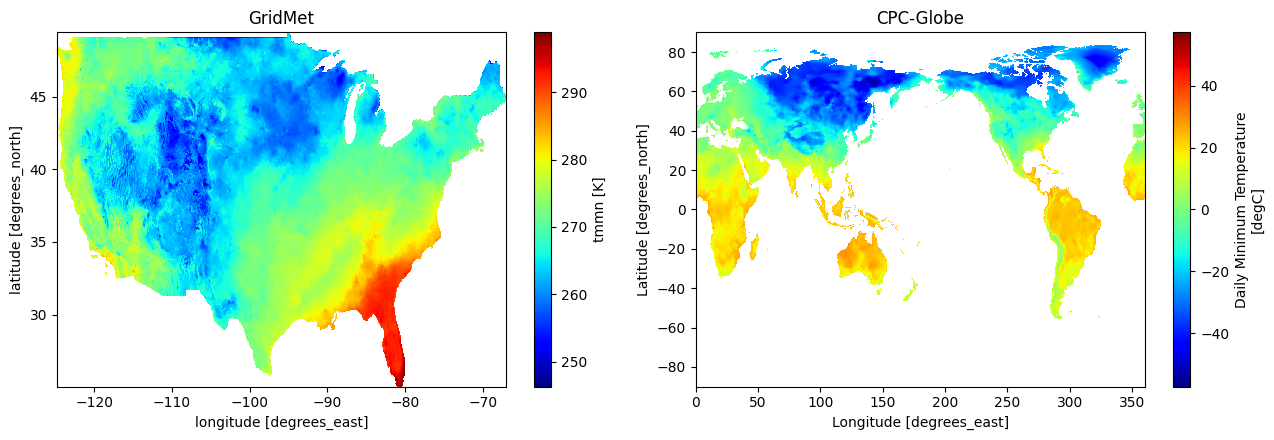

In [28]:
# Let's plot the original data for Jan 1st:
fig = plt.figure(figsize = [13,4.5])
plt.subplot(1,2,1)
ds_gridmet.air_temperature[0,:,:].plot(cmap = 'jet')
plt.title('GridMet')
plt.subplot(1,2,2)
ds_CPC.tmin[0,:,:].plot(cmap = 'jet')
plt.title('CPC-Globe')
plt.tight_layout()

Looking at the two datasets, we see that there are a few differences that should be addressed:
+ In the gridmet dataset, the "crs" coordinate can be dropped, and the "day" coordinate can be renamed to "time" to be consistent with the CPC dataset (similarly for "air_temperature").
+ The gridmet data is in Kelvin, but CPC is in Celcius. Let's convert gridmet data to Celcius.
+ In addition, the lon coordinate in one dataset is 0:360 and -180:180 in the other one. Let's change that to 0:360 for the gridmet data.
+ Lastly, let's interpolate the finer resolution data (gridmet) to the CPC-Globe spatial resolution.

In [29]:
ds_gridmet_revised = ds_gridmet.drop('crs').rename({'day':'time', 'air_temperature':'tmin'})
ds_gridmet_revised = ds_gridmet_revised-273.15 # Convert Kelvin to Celcius
lon_revised = ds_gridmet.lon + (ds_gridmet.lon < 0)*360
ds_gridmet_revised = ds_gridmet_revised.assign_coords(lon = lon_revised)

<ipython-input-29-4c240538214a>:1: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  ds_gridmet_revised = ds_gridmet.drop('crs').rename({'day':'time', 'air_temperature':'tmin'})


In [30]:
ds_gridmet_revised

<xarray.Dataset> Size: 2GB
Dimensions:  (lat: 585, time: 365, lon: 1386)
Coordinates:
  * lat      (lat) float64 5kB 49.4 49.36 49.32 49.28 ... 25.15 25.11 25.07
  * time     (time) datetime64[ns] 3kB 2021-01-01 2021-01-02 ... 2021-12-31
  * lon      (lon) float64 11kB 235.2 235.3 235.3 235.4 ... 292.9 292.9 292.9
Data variables:
    tmin     (time, lat, lon) float64 2GB nan nan nan nan ... nan nan nan nan
Attributes: (12/19)
    geospatial_bounds_crs:      EPSG:4326
    Conventions:                CF-1.6
    geospatial_bounds:          POLYGON((-124.7666666333333 49.40000000000000...
    geospatial_lat_min:         25.066666666666666
    geospatial_lat_max:         49.40000000000000
    geospatial_lon_min:         -124.7666666333333
    ...                         ...
    date:                       30 March 2023
    note1:                      The projection information for this file is: ...
    note2:                      Citation: Abatzoglou, J.T., 2013, Development...
    note3:                      Data in slices after last_permanent_slice (1-...
    note4:                      Data in slices after last_provisional_slice (...
    note5:                      Days correspond approximately to calendar day...

In [31]:
# The memory was crashing to proceed from here. Therefore, let's delete the
# variable ds_gridmet which is not going to be used anymore.
del ds_gridmet

In [32]:
# This one seems to crash the memory.
# ds_gridmet_interp = ds_gridmet_revised.interp(lat = ds_CPC.lat, lon = ds_CPC.lon)

Great! We did all that with just a few lines of code. Please note that in interpolation, the data boundary (i.e. latlon bounds) are also matched to the output boundary.

Now let's take a look at Feb 16, 2021 for the regions in Texas, where a severe cold storm happened. I did a quick analysis for that event last year and you can take a look at that in this link: https://www.linkedin.com/pulse/how-unusual-2021-texas-cold-span-ali-ahmadalipour/

To make the temporal analyses easier, we first make sure that the "time" coordinate is in proper datetime format.

In [33]:
ds_gridmet_revised

<xarray.Dataset> Size: 2GB
Dimensions:  (lat: 585, time: 365, lon: 1386)
Coordinates:
  * lat      (lat) float64 5kB 49.4 49.36 49.32 49.28 ... 25.15 25.11 25.07
  * time     (time) datetime64[ns] 3kB 2021-01-01 2021-01-02 ... 2021-12-31
  * lon      (lon) float64 11kB 235.2 235.3 235.3 235.4 ... 292.9 292.9 292.9
Data variables:
    tmin     (time, lat, lon) float64 2GB nan nan nan nan ... nan nan nan nan
Attributes: (12/19)
    geospatial_bounds_crs:      EPSG:4326
    Conventions:                CF-1.6
    geospatial_bounds:          POLYGON((-124.7666666333333 49.40000000000000...
    geospatial_lat_min:         25.066666666666666
    geospatial_lat_max:         49.40000000000000
    geospatial_lon_min:         -124.7666666333333
    ...                         ...
    date:                       30 March 2023
    note1:                      The projection information for this file is: ...
    note2:                      Citation: Abatzoglou, J.T., 2013, Development...
    note3:                      Data in slices after last_permanent_slice (1-...
    note4:                      Data in slices after last_provisional_slice (...
    note5:                      Days correspond approximately to calendar day...

In [34]:
ds_gridmet_revised = ds_gridmet_revised.assign_coords(
    time = pd.to_datetime(ds_gridmet_revised.time))
ds_CPC = ds_CPC.assign_coords(
    time = pd.to_datetime(ds_CPC.time))

In [35]:
target_date = datetime.date(2021,2,16)
target_date = pd.to_datetime(target_date)

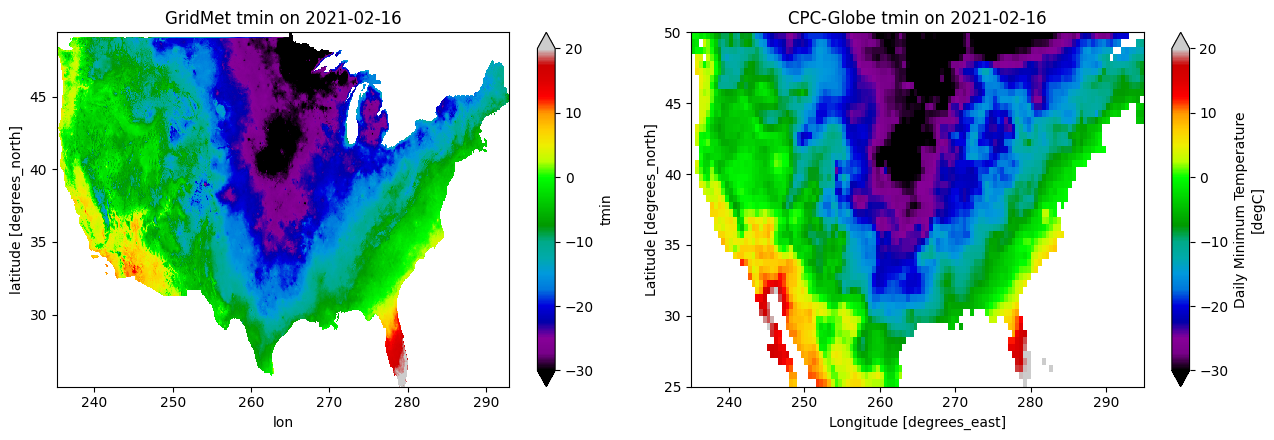

In [36]:
fig = plt.figure(figsize = [13,4.5], facecolor='w')
plt.subplot(1,2,1)
ds_gridmet_revised.sel(time=target_date).tmin.plot(
    cmap = 'nipy_spectral', vmin = -30, vmax = 20)
plt.title(f'GridMet tmin on {target_date.strftime("%Y-%m-%d")}')

plt.subplot(1,2,2)
ds_CPC.sel(time=target_date).tmin.plot(
    cmap = 'nipy_spectral', vmin = -30, vmax = 20)
plt.title(f'CPC-Globe tmin on {target_date.strftime("%Y-%m-%d")}')
plt.xlim([235,295])
plt.ylim([25,50])
plt.tight_layout()

It can be seen that the interpolated data (CPC plot shown on right) does not necessarily have the details (specially the orographic and elevation effects) of the finer resolution data.

Now let's find the spatial mean of both datasets around Austin, TX. Again, to make it simpler, I defined an estimate rectangular boundary that we will use.

In [37]:
# Estimated boundaries for Austin, TX:
left = 360 - 97.9
right = 360 - 97.6
top = 30.5
bottom = 30.2

In [38]:
ds_Austin_gridmet = ds_gridmet_revised.isel(
    lon=(ds_gridmet_revised.lon >= left) & (ds_gridmet_revised.lon <= right),
    lat=(ds_gridmet_revised.lat >= bottom) & (ds_gridmet_revised.lat <= top),
).mean(dim=['lat','lon'])
ds_Austin_CPC = ds_CPC.isel(
    lon=(ds_CPC.lon >= left) & (ds_CPC.lon <= right),
    lat=(ds_CPC.lat >= bottom) & (ds_CPC.lat <= top),
).mean(dim=['lat','lon'])

Now let's plot the two timeseries, but this time in degrees fahrenheit:

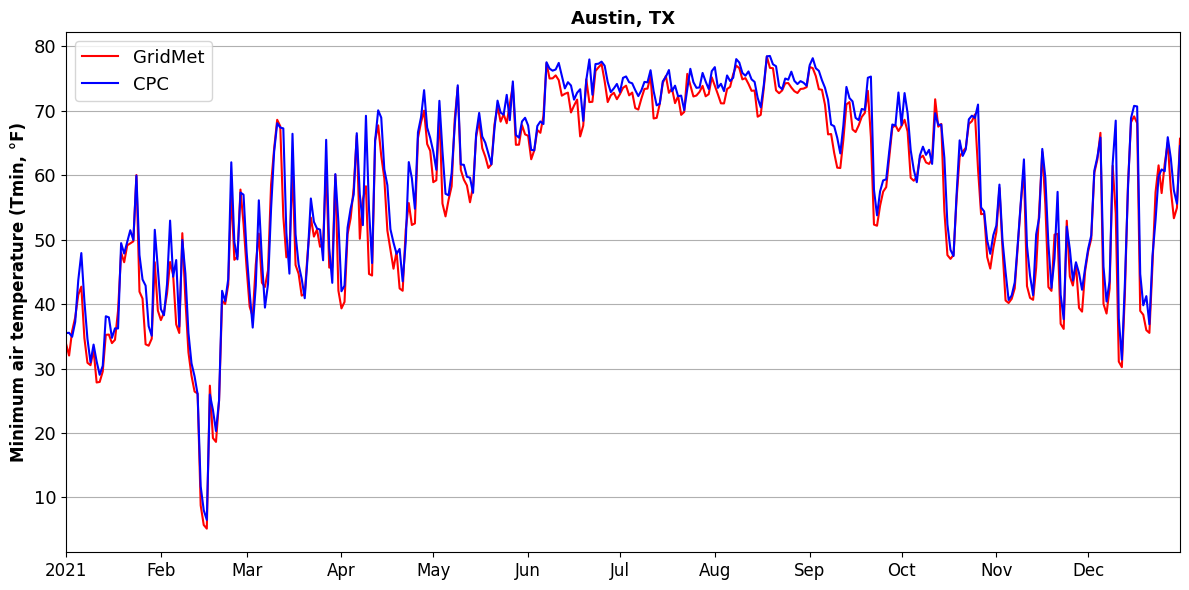

In [39]:
plt.figure(figsize = [12,6])
(ds_Austin_gridmet.tmin*1.8 + 32).plot(label = 'GridMet', color = 'r')
(ds_Austin_CPC.tmin*1.8 + 32).plot(label = 'CPC', color = 'b')
plt.grid(axis='y')
plt.xticks(ticks = [datetime.date(2021,x,1) for x in range(1,13)], fontsize=12)
plt.xlim([datetime.date(2021,1,1), datetime.date(2021,12,31)])
plt.yticks(fontsize=13)
plt.ylabel('Minimum air temperature (Tmin, °F)', fontsize = 12,
           fontweight = 'bold')
plt.xlabel('')
plt.legend(fontsize=13, loc = 'upper left')
plt.title('Austin, TX', fontsize=13, fontweight = 'bold')
plt.tight_layout()

As you can see, the two datasets are considerably different (more than 10°F) in late February and late October. Notably, daily temperature has a lot of noise (short-term variation). To have a smoother plot, let's calculate the moving average of tmin with a 15-day window:

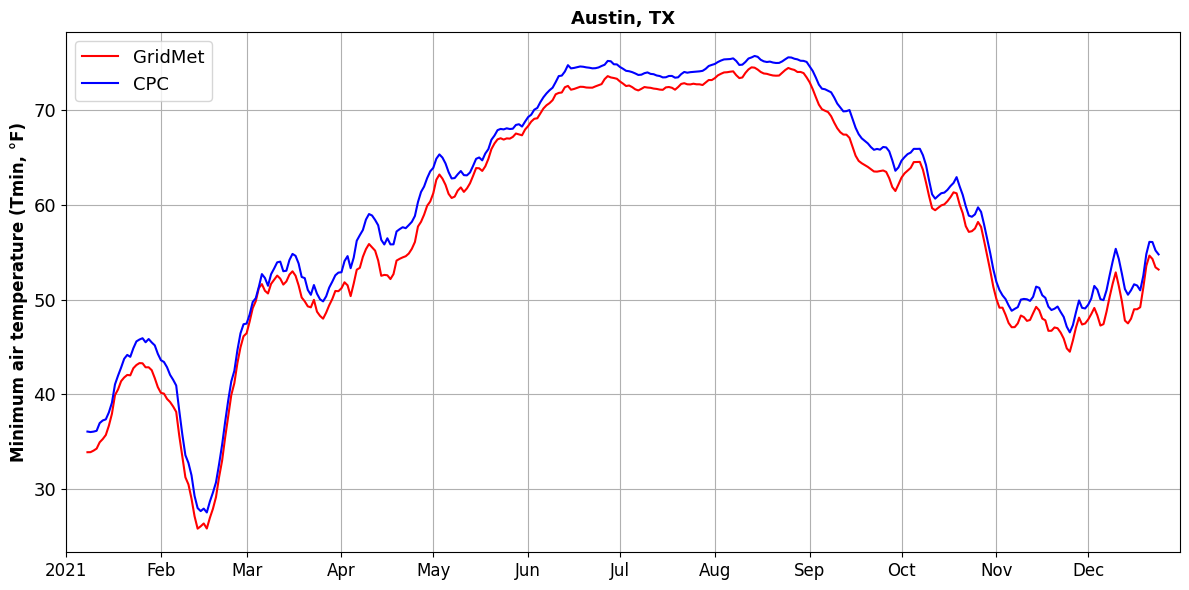

In [40]:
plt.figure(figsize = [12,6])
(ds_Austin_gridmet.tmin*1.8 + 32).rolling(time=15,center=True).mean().plot(label = 'GridMet', color = 'r')
(ds_Austin_CPC.tmin*1.8 + 32).rolling(time=15,center=True).mean().plot(label = 'CPC', color = 'b')
plt.grid()
plt.xticks(ticks = [datetime.date(2021,x,1) for x in range(1,13)], fontsize=12)
plt.xlim([datetime.date(2021,1,1), datetime.date(2021,12,31)])
plt.yticks(fontsize=13)
plt.ylabel('Minimum air temperature (Tmin, °F)', fontsize = 12,
           fontweight = 'bold')
plt.xlabel('')
plt.legend(fontsize=13, loc = 'upper left')
plt.title('Austin, TX', fontsize=13, fontweight = 'bold')
plt.tight_layout()

Awesome! We are done with the intermediate example. You should now be able to replicate similar analyses for various datasets. There are a lot of other things that can be adjusted to make the plots more interesting. You can always search for anything you'd like to do and you will most likely find a decent answer for it on stackoverflow.

# 3. Advanced (skip data download, anomaly calculation, timelapse animation):

## 3.1. Seasonal Forecast:

In this part, we will analyze seasonal forecast data on the go (without downloading and saving the data on the disk). Then, we will look at calculating monthly anomaly (departure of each month from its historical mean state).

The data that we will be focusing on is going to be the [NMME](https://www.cpc.ncep.noaa.gov/products/NMME/) seasonal climate prediction, which is a global dataset of 1 degree (~ 100km) spatial resolution and monthly temporal resolution with multiple months ahead forecast lead time. To make the analysis simpler, we will only focus on just one model (instead of the entire ensemble of available NMME models). Let's go!

In [41]:
import xarray as xr
import matplotlib.pyplot as plt
import datetime
import pandas as pd

In [42]:
url = 'http://iridl.ldeo.columbia.edu/SOURCES/.Models/.NMME/.GFDL-SPEAR/.FORECAST/.MONTHLY/.tref/dods'

In [43]:
ds = xr.open_dataset(url,engine='netcdf4',decode_times=False)

In [44]:
ds

<xarray.Dataset> Size: 5GB
Dimensions:  (Y: 181, Z: 1, L: 12, S: 49, M: 30, X: 360)
Coordinates:
  * Y        (Y) float32 724B -90.0 -89.0 -88.0 -87.0 ... 87.0 88.0 89.0 90.0
  * Z        (Z) float32 4B 2.0
  * L        (L) float32 48B 0.5 1.5 2.5 3.5 4.5 5.5 6.5 7.5 8.5 9.5 10.5 11.5
  * S        (S) float32 196B 731.0 732.0 733.0 734.0 ... 777.0 778.0 779.0
  * M        (M) float32 120B 1.0 2.0 3.0 4.0 5.0 ... 26.0 27.0 28.0 29.0 30.0
  * X        (X) float32 1kB 0.0 1.0 2.0 3.0 4.0 ... 356.0 357.0 358.0 359.0
Data variables:
    tref     (S, L, M, Z, Y, X) float32 5GB ...
Attributes:
    Conventions:  IRIDL

The NMME coordinates are not really self-explanatory. So, here's an overview of what each coordinate stands for:
+ S: Time (number of months since 1960-Jan-1)
+ M: Ensemble member
+ X: Longitude (in 0 0:360 format)
+ L: Leadtime (in months; 0.5 indicating the current month, 1.5 being one month ahead, and so on)
+ Y: Latitude
+ *Z: this variable is only found in the GFDL model for temperature forecast, and it indicates that the data is at 2m height from ground.

To make the data more descriptive and more convenient for analysis, we need to modify it first:

In [45]:
ds = ds.rename({'S':'time', 'X':'lon', 'Y':'lat'})

In [46]:
start_date_NMME = pd.to_datetime(datetime.date(1960,1,1))
time_new = [start_date_NMME + pd.DateOffset(months = x) for x in ds.time.values]
ds = ds.assign_coords(time = time_new)
if 'Z' in ds.dims:
    ds = ds.squeeze(dim = 'Z').drop('Z')

<ipython-input-46-9a85cef0d2e4>:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  ds = ds.squeeze(dim = 'Z').drop('Z')


In [47]:
ds

<xarray.Dataset> Size: 5GB
Dimensions:  (lat: 181, L: 12, M: 30, lon: 360, time: 49)
Coordinates:
  * lat      (lat) float32 724B -90.0 -89.0 -88.0 -87.0 ... 87.0 88.0 89.0 90.0
  * L        (L) float32 48B 0.5 1.5 2.5 3.5 4.5 5.5 6.5 7.5 8.5 9.5 10.5 11.5
  * M        (M) float32 120B 1.0 2.0 3.0 4.0 5.0 ... 26.0 27.0 28.0 29.0 30.0
  * lon      (lon) float32 1kB 0.0 1.0 2.0 3.0 4.0 ... 356.0 357.0 358.0 359.0
  * time     (time) datetime64[ns] 392B 2020-12-01 2021-01-01 ... 2024-12-01
Data variables:
    tref     (time, L, M, lat, lon) float32 5GB ...
Attributes:
    Conventions:  IRIDL

The above dataset has all the available forecast data for all leadtimes. We can now select our area of interest and limit the leadtime to our use case. For this example, let's take a look at the temperature forecast for Feb 2021 that was generated at the beginning of the same month (i.e. lead 0.5):

In [48]:
target_date = pd.to_datetime(datetime.date(2021,2,1))
ds_sel = ds.sel(time=target_date).isel(L=0)
# Note the difference use of "sel" and "isel". For the former, you should indicate
# the exact value to be selected, but for the latter, the index should be specified.

So far, the data is not loaded yet (although we can see all the metadata). To make the analysis easier, we will first load the data and then continue with the rest of analyses. For loading data, I am simply using .load(), but a better way of doing so is to use Dask and do the work in parallel mode. I won't go into that (partly because I tried it in Google Colab, and I was getting several errors here, and I didn't want to spend too much time on debugging).

In [49]:
ds_sel.load() # this can take a couple of minutes or so

<xarray.Dataset> Size: 8MB
Dimensions:  (lat: 181, M: 30, lon: 360)
Coordinates:
  * lat      (lat) float32 724B -90.0 -89.0 -88.0 -87.0 ... 87.0 88.0 89.0 90.0
    L        float32 4B 0.5
  * M        (M) float32 120B 1.0 2.0 3.0 4.0 5.0 ... 26.0 27.0 28.0 29.0 30.0
  * lon      (lon) float32 1kB 0.0 1.0 2.0 3.0 4.0 ... 356.0 357.0 358.0 359.0
    time     datetime64[ns] 8B 2021-02-01
Data variables:
    tref     (M, lat, lon) float32 8MB nan nan nan nan nan ... nan nan nan nan
Attributes:
    Conventions:  IRIDL

Now let's plot the data and explore it a bit:

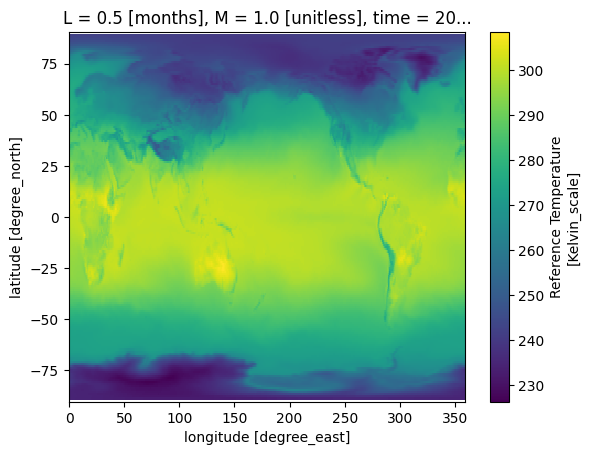

In [50]:
ds_sel.tref[0,:,:].plot()

Now let's calculate the standard deviation of forecasts among the ensemble members, and then plot them for the entire globe as well as only North America:

In [51]:
ds_std = ds_sel.std(dim='M')

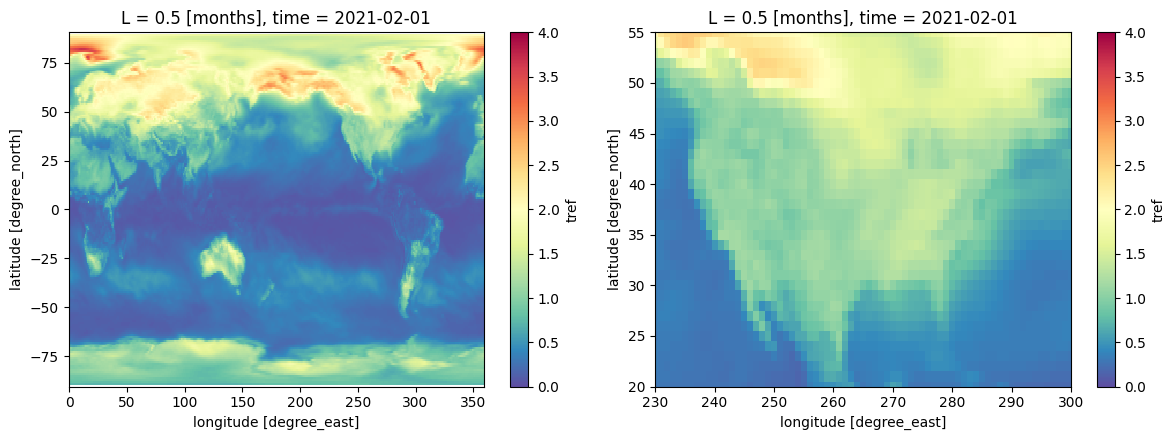

In [52]:
plt.figure(figsize=[12,4.5])
plt.subplot(1,2,1)
ds_std.tref.plot(cmap = 'Spectral_r', vmin = 0, vmax = 4)
plt.subplot(1,2,2)
ds_std.tref.plot(cmap = 'Spectral_r', vmin = 0, vmax = 4)
plt.xlim([230,300])
plt.ylim([20,55])
plt.tight_layout()

Looking at the above plots, we can see that the uncertainty of temperature forecast in February 2021 is much higher across the northern latitudes (i.e. in winter) than the southern latitudes (i.e. in summer).

Now let's check if the forecasts indicated any significant cold anomaly for Feb 2021 across the Midwest US and Southern Plains. To do so, we need to load the climatology (historical mean) of GFDL forecasts and then find the anomaly by subtracting it from forecasts. In other words:
- Anomaly = Forecast - Climatology

In [53]:
ds_clim = xr.open_dataset('http://iridl.ldeo.columbia.edu/SOURCES/.Models/.NMME/.GFDL-SPEAR/.HINDCAST/.mc9120/.tref/dods',
                          decode_times=False)

In [54]:
# Again, to make things easier, we first load the climatology into RAM:
ds_clim.load()

<xarray.Dataset> Size: 75MB
Dimensions:  (Y: 181, L: 12, X: 360, S: 12)
Coordinates:
  * Y        (Y) float32 724B -90.0 -89.0 -88.0 -87.0 ... 87.0 88.0 89.0 90.0
  * L        (L) float32 48B 0.5 1.5 2.5 3.5 4.5 5.5 6.5 7.5 8.5 9.5 10.5 11.5
  * X        (X) float32 1kB 0.0 1.0 2.0 3.0 4.0 ... 356.0 357.0 358.0 359.0
  * S        (S) float32 48B 0.0 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 11.0
Data variables:
    tref     (S, L, Y, X) float64 75MB nan nan nan nan nan ... nan nan nan nan
Attributes:
    Conventions:  IRIDL

In the above dataset, S indicates the month index (0 corresponding to January and 11 indicating December). We should adjust the coordinates of this climatology dataset and match it to the "ds_sel" that we prepared above:

In [55]:
ds_clim = ds_clim.rename({'X':'lon', 'Y':'lat'})

In [56]:
ds_clim_sel = ds_clim.isel(L = 0).sel(S = 1).drop(['S','L']) # S=1 for selecting February

<ipython-input-56-7927d8380f3a>:1: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  ds_clim_sel = ds_clim.isel(L = 0).sel(S = 1).drop(['S','L']) # S=1 for selecting February


In [57]:
ds_anom = ds_sel - ds_clim_sel

(20.0, 55.0)

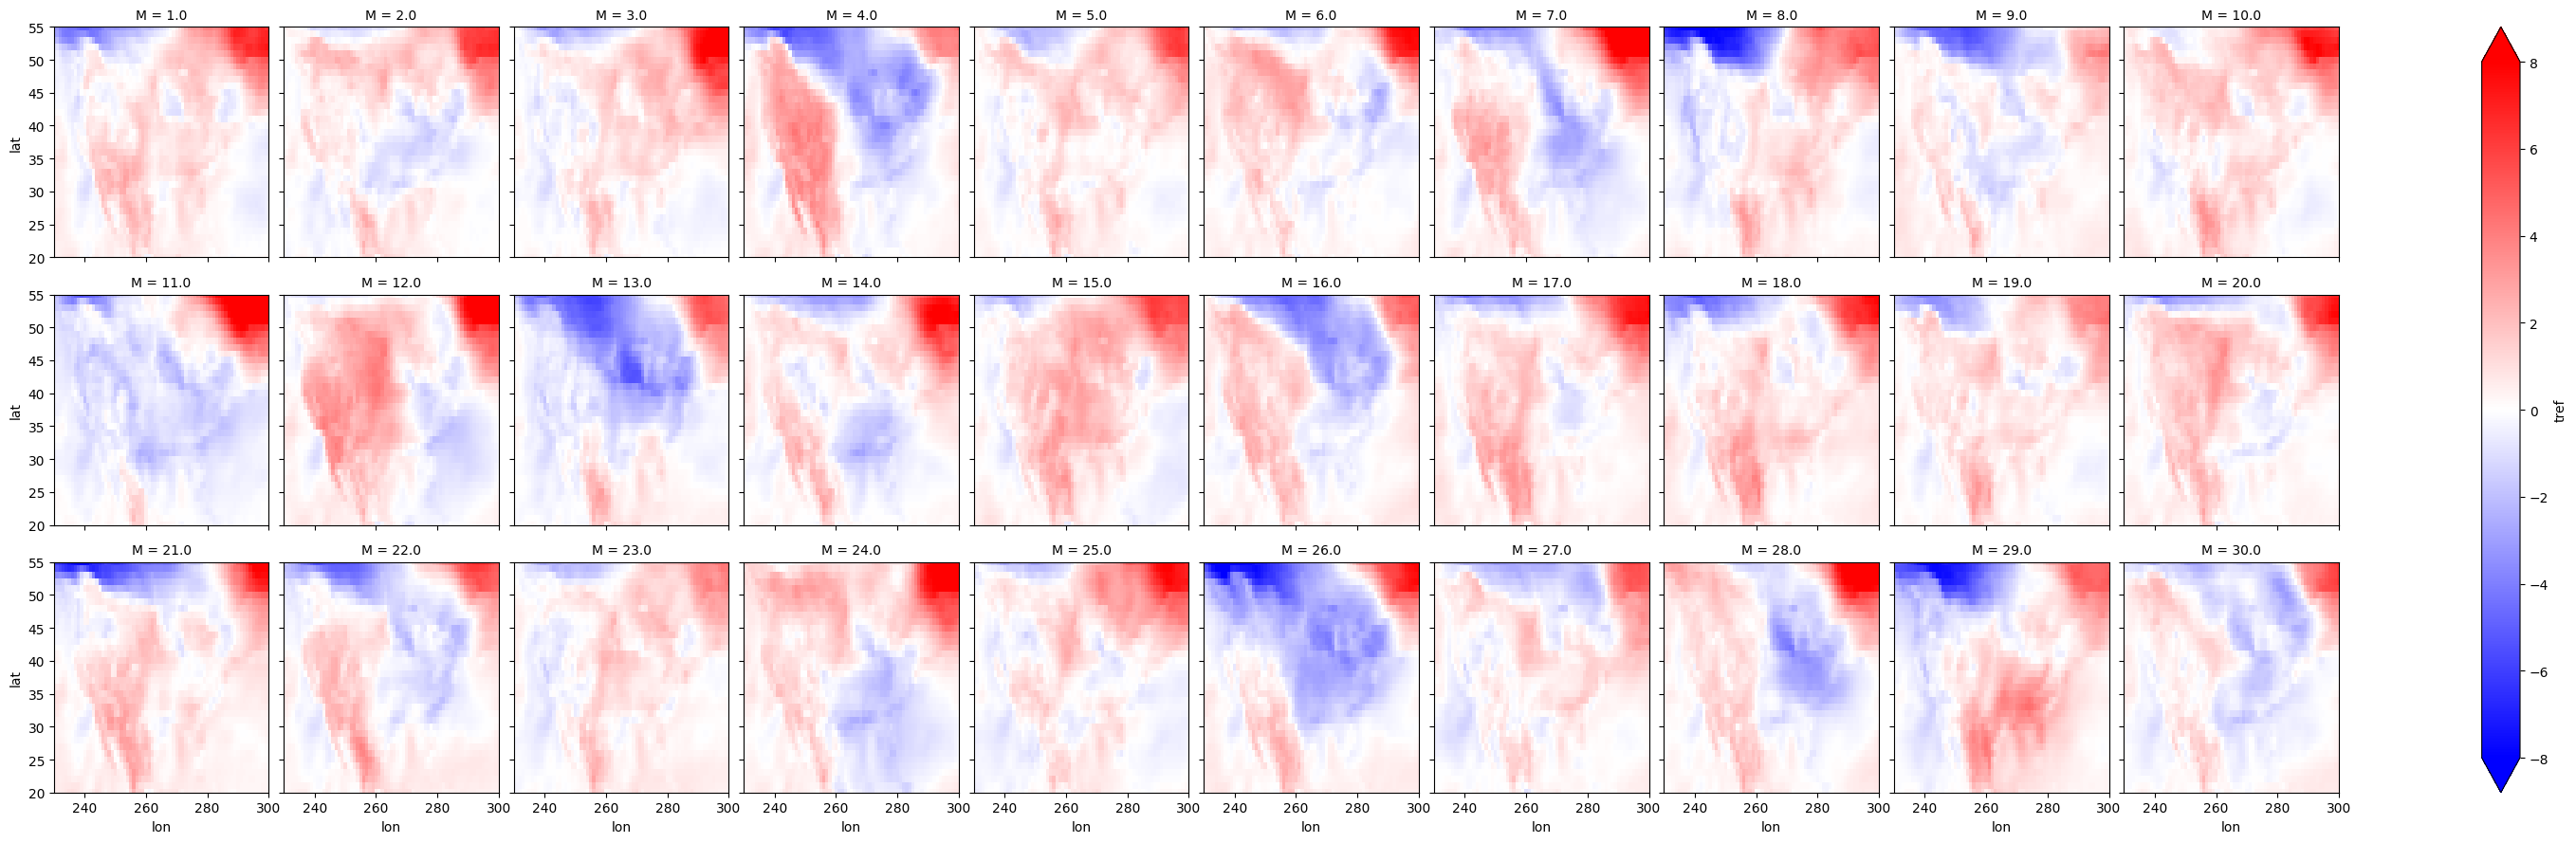

In [58]:
ds_anom.tref.plot(col = 'M', col_wrap = 10, vmin = -8, vmax = 8, cmap = 'bwr')
plt.xlim([230,300])
plt.ylim([20,55])

As it can be seen, most of the ensemble members of the GFDL-SPEAR model correctly forecasted negative anomaly (i.e. colder than usual condition) for the majority of Midwest US and Texas. Notably, this is the Lead-0 forecast, which was initiated at the beginning of Feb for the month of Feb (thus, basically a couple of weeks ahead). If we look back at lead-1 or beyond, such a strong pattern and consensus are not found.

(20.0, 55.0)

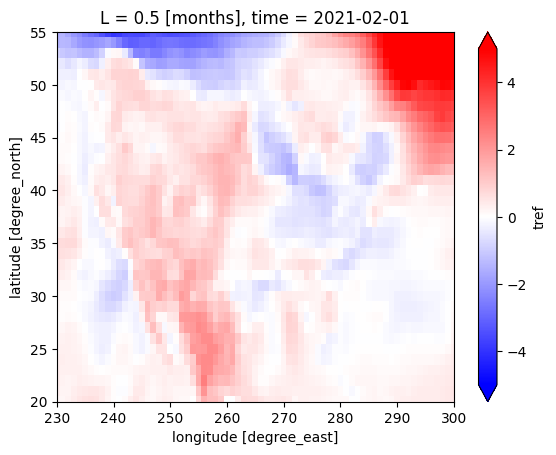

In [59]:
# And here's the ensemble mean plot:
ds_anom.mean(dim='M').tref.plot(cmap='bwr', vmax=5, vmin=-5)
plt.xlim([230,300])
plt.ylim([20,55])

I was hoping to use two more libraries in this section:
+ **dask** --> for parallel computing
+ **cartopy** --> for customized mapping with geographic projection

However, I ran into several errors trying to use them on Google Colab, so I decided to exclude them from the advanced section. But if you really want to reach an advanced proficiency level, I highly encourage you to try dask and cartopy.

---

## 3.2. Climate change assessment using CMIP6 data:

I thought it would be really useful to have a quick exercise for analyzing climate change data. In this part, we will explore CMIP6 air temperature projections from one model. We will look at monthly data for the historical period of 1970-2010 and future projections of SSP585 during 2010-2100.


In [60]:
!pip install gcsfs # this will take a few seconds. We need it to extract CMIP6 data from Google Cloud Storage.

# We will be opening zarr data format, which is a relatively new data structure
# that is practical for geospatial datasets. The pre-installed xarray on google
# colab does not allow this. So, we need to intall the complete version of xarray.
!pip install xarray[complete] # (adding this again in case someone wants to start from this part)

In [61]:
from matplotlib import pyplot as plt
import pandas as pd
import xarray as xr
import gcsfs
import datetime
import os

In [62]:
df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')

In [63]:
df.head()

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,ps,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
1,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,rsds,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
2,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,rlus,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
3,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,rlds,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
4,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,psl,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706


In [64]:
len(df)

523774

The df table includes information for all climate change model runs that are available on Google Cloud Storage. As of March 2022, there are over half a million different model outputs (e.g. different models, variables, timescales, scenarios, ensemble member, etc.). Let's narrow down the outputs to only those of monthly air temperature in historical and ssp585 scenario:

In [65]:
df_ssp585 = df.query("activity_id=='ScenarioMIP' & table_id == 'Amon' & " +\
    "variable_id == 'tas' & experiment_id == 'ssp585' & member_id == 'r1i1p1f1'")
print('Length of df_ssp585:', len(df_ssp585))
df_ssp585.head(3)

Length of df_ssp585: 35


,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
866,ScenarioMIP,NOAA-GFDL,GFDL-CM4,ssp585,r1i1p1f1,Amon,tas,gr1,gs://cmip6/CMIP6/ScenarioMIP/NOAA-GFDL/GFDL-CM...,NaN,20180701
19008,ScenarioMIP,NOAA-GFDL,GFDL-ESM4,ssp585,r1i1p1f1,Amon,tas,gr1,gs://cmip6/CMIP6/ScenarioMIP/NOAA-GFDL/GFDL-ES...,NaN,20180701
66586,ScenarioMIP,BCC,BCC-CSM2-MR,ssp585,r1i1p1f1,Amon,tas,gn,gs://cmip6/CMIP6/ScenarioMIP/BCC/BCC-CSM2-MR/s...,NaN,20190314


In [66]:
df_historical = df.query("activity_id == 'CMIP' & table_id == 'Amon' & " +\
    "variable_id == 'tas' & experiment_id == 'historical' & member_id == 'r1i1p1f1'")
print('Length of df_historical:', len(df_historical))
df_historical.head(3)

Length of df_historical: 55


,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
8074,CMIP,NOAA-GFDL,GFDL-CM4,historical,r1i1p1f1,Amon,tas,gr1,gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-CM4/histo...,NaN,20180701
29231,CMIP,IPSL,IPSL-CM6A-LR,historical,r1i1p1f1,Amon,tas,gr,gs://cmip6/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/histor...,NaN,20180803
32351,CMIP,NASA-GISS,GISS-E2-1-G,historical,r1i1p1f1,Amon,tas,gn,gs://cmip6/CMIP6/CMIP/NASA-GISS/GISS-E2-1-G/hi...,NaN,20180827


Ok, much better. In summary, our CMIP6 search is narrowed down to 55 historical models and 35 ssp585 future monthly temperature "forecasts". In a decent climate change study, we should first evaluate the models during the historical period and then select a sub-set of models that outperform at the region of interest. However, since this is just an exercise, I will only choose one model that has data in both historical and future periods.

In [67]:
model = 'GFDL-CM4'
zstore_hist = df_historical.query(f"source_id == '{model}'").zstore.values[0]
zstore_ssp585 = df_ssp585.query(f"source_id == '{model}'").zstore.values[0]
gcs = gcsfs.GCSFileSystem(token='anon')

In [ ]:
mapper = gcs.get_mapper(zstore_hist)
ds_hist = xr.open_zarr(mapper, consolidated = True)
mapper = gcs.get_mapper(zstore_ssp585)
ds_ssp585 = xr.open_zarr(mapper, consolidated = True)

In [ ]:
ds_hist

Looking at the metadata of the two datasets, the data periods can be beyond our interest (historical: 1850-2014, ssp585: 2015-2100). Therefore, we can select our period of interest and then load the subset of data for more convenience in further analyses. But before that, the time coordinate is in "object" format, which we need to convert to datetime to be able to easily analyze the timeseries.

In [ ]:
print('hist date range  :', ds_hist.time[0].values, ' , ', ds_hist.time[-1].values)
print('ssp585 date range:', ds_ssp585.time[0].values, ' , ', ds_ssp585.time[-1].values)

In [ ]:
start_time = pd.to_datetime(datetime.date(1850,1,15)) # I chose 15 for all dates to make it easier.
time_new_hist = [start_time + pd.DateOffset(months = x) for x in range(len(ds_hist.time))]

start_time = pd.to_datetime(datetime.date(2015,1,15))
time_new_ssp585 = [start_time + pd.DateOffset(months = x) for x in range(len(ds_ssp585.time))]

In [ ]:
ds_hist = ds_hist.assign_coords(time = time_new_hist)
ds_ssp585 = ds_ssp585.assign_coords(time = time_new_ssp585)

In [ ]:
start_date = pd.to_datetime(datetime.date(1980,1,1))
end_date = pd.to_datetime(datetime.date(2010,12,31))
ds_hist_sel = ds_hist.isel(time=(ds_hist.time >= start_date) & (ds_hist.time <= end_date))

start_date = pd.to_datetime(datetime.date(2070,1,1))
end_date = pd.to_datetime(datetime.date(2099,12,31))
ds_ssp585_sel = ds_ssp585.isel(time=(ds_ssp585.time >= start_date) & (ds_ssp585.time <= end_date))

In [ ]:
ds_hist_sel.load()
ds_ssp585_sel.load()

Great! Now let's take a look at the average monthly temperature change over the globe in distant future:

In [ ]:
tas_avg_hist = ds_hist_sel.groupby('time.month').mean()
tas_avg_ssp585 = ds_ssp585_sel.groupby('time.month').mean()

In [ ]:
tas_30yr_diff = tas_avg_ssp585 - tas_avg_hist

In [ ]:
tas_30yr_diff.tas.plot(col = 'month', col_wrap = 6, vmax = 10, vmin = 0, cmap = 'hot_r')

And here's a plot for the annual mean change:

In [ ]:
tas_30yr_diff.mean('month').tas.plot(figsize=[8,5], cmap = 'hot_r',
                                     vmin = 0, vmax = 10)
plt.title('Mean temperature change: 2070-2100 vs. 1980-2010')
plt.tight_layout()

The above plots show that in an extreme scenario (ssp585), the annual mean temperature in northern latitudes can be above 10°C warmer than the historical period, and the same for mid-latitudes can be ~5-7°C warmer. Please note that this is the result of one GCM realization at coarse resolution. In practice, these outputs should be first bias-corrected and downscaled before further analysis.

Now, let's try an example and work with timeseries data (instead of 30-year mean). Let's look at the annual temperature change of each year.

In [ ]:
tas_avg_hist_yr = tas_avg_hist.mean('month')

In [ ]:
tas_change_yr = ds_ssp585_sel.groupby('time.year').mean('time')

In [ ]:
tas_change_yr = tas_change_yr - tas_avg_hist_yr

### Creating a timelapse:

Now, let's make a timelapse video for annual temperature change. To have a smooth video, we'll plot the 5-year rolling average.

In [ ]:
tas_change_yr_rolling5 = tas_change_yr.rolling(year=5,center=True).mean().dropna('year').tas
# Make a directory to save all the figures there:
if not os.path.exists('./Figures_ssp585/'):
    os.makedirs('./Figures_ssp585/')

for i in range(len(tas_change_yr_rolling5)):
    dataplot = tas_change_yr_rolling5[i,:,:]
    # Convert 0:360 to -180:180 :
    dataplot = dataplot.assign_coords(lon = dataplot.lon - (dataplot.lon > 180)*360)
    dataplot = dataplot.sortby('lon', ascending=True)

    fig = plt.figure(figsize=[9,5], facecolor='w')
    # Adjust plot area (I find these by try and error until I get what I want)
    plt.subplots_adjust(left=0.075, right=0.895, bottom=0.1, top=0.93)
    plt.pcolormesh(dataplot.lon, dataplot.lat, dataplot, cmap='plasma', vmin=0, vmax=12)
    plt.title(f'Near-surface air temperature change: {model} ssp585, {dataplot.year.values} vs. 1980-2010',
              fontsize = 14)
    plt.ylabel('Latitude', fontsize = 12)
    plt.xlabel('Longitude', fontsize = 12)
    # Add colorbar:
    cax = fig.add_axes([0.91, 0.12, 0.02, 0.8])
    cb = plt.colorbar(cax=cax, orientation='vertical', extend = 'max')
    cb.ax.tick_params(labelsize=11)
    cb.set_label(label='Temperature Change (°C)', color = 'k', size=13)
    # Save and close figure:
    plt.savefig(f'./Figures_ssp585/Fig_tasChange_{dataplot.year.values}.png',
                format = 'png', dpi=200)
    plt.close()

Great! Now we have saved all the figures. We can use different libraries to generate a timelapse (/animation) from the figures. I will use **[openCV](https://docs.opencv.org/4.x/d6/d00/tutorial_py_root.html)** here, which is an amazing library for image processing and you can also leverage it for different applications in climate data analysis (e.g. spatial smoothing, applying filters or weighted kernels to emphasize on edges for feature detection/extraction, or use it for data augmentation in computer vision applications). OpenCV requires a whole tutorial on its own and I'm not going to go in details here. But again, if you intend to be an advanced user, I highly recommend working with OpenCV.

In [ ]:
import cv2
import glob

In [ ]:
files = glob.glob(f'./Figures_ssp585/Fig_tasChange*.png')
files.sort()

In [ ]:
img_array = []
for filename in files:
    img = cv2.imread(filename)
    height, width, layers = img.shape
    size = (width,height)
    img_array.append(img)
fps = 4
out = cv2.VideoWriter(f'Vid_tasChange_ssp585.mp4',cv2.VideoWriter_fourcc(*'MP4V'), 4, size)
for i in range(len(img_array)):
    out.write(img_array[i])
out.release()

There we go! We were able to load CMIP6 data directly from Google Cloud Storage, analyze the data, generate figures, and then make a timelapse animation. Remember that after you close the Colab (or if your session is terminated for any reason), you will lose all the results. So, if you want to keep any of this result, you can either download it to your local computer or save/copy the output to your own Google Drive.

### Generate simple timeseries plot:

We can define a region of interest and explore the spatial mean of the temperature change. For this example, we'll focus on the Northwest US (e.g. the Cascades):

In [ ]:
left = 236
right = 240
bottom = 42
top = 49

In [ ]:
tas_NW_yr_hist = ds_hist_sel.isel(lat = (ds_hist_sel.lat>=bottom) & (ds_hist_sel.lat<=top),
                   lon = (ds_hist_sel.lon>=left) & (ds_hist_sel.lon<=right),
                   ).mean(['lat','lon']).drop(['bnds', 'height', 'time_bnds'])
tas_NW_yr_ssp585 = ds_ssp585_sel.isel(lat = (ds_ssp585_sel.lat>=bottom) & (ds_ssp585_sel.lat<=top),
                   lon = (ds_ssp585_sel.lon>=left) & (ds_ssp585_sel.lon<=right),
                   ).mean(['lat','lon']).drop(['bnds', 'height', 'time_bnds'])

In [ ]:
plt.figure(figsize=[8,5],)
(tas_NW_yr_hist.groupby('time.year').mean().tas-273.15).plot(
    label='historical', color='b', linewidth=2)
(tas_NW_yr_ssp585.groupby('time.year').mean().tas-273.15).plot(
    label='ssp585', color='r', linewidth=2)
plt.grid()
plt.xlim([1980,2100])
plt.legend(fontsize=13)
plt.xticks(fontsize=12)
plt.yticks(fontsize=13)
plt.ylabel('Average Annual Temperature (°C)', fontsize=13, fontweight='bold')
plt.xlabel('Year', fontsize=13, fontweight='bold')
plt.title(f'Average Annual air temperature in the Cascades: {model} ssp585',
          fontsize=15)

plt.tight_layout()

That concludes the advanced section of this tutorial. I hope you found it useful. Suggestions and feedbacks are appreciated.

---
---

# 4. Advanced+ (Machine Learning):

I shared a case study more than a year ago where I used climate data to predict wildfire frequency in California. It is a relatively simple study and should be a good exercise for developing a machine learning prediction model. I have shared all the codes and explained the process in this link:
https://www.linkedin.com/pulse/ai-climate-data-predicting-fire-frequency-california-ali-ahmadalipour/